# Projet CENSE

In [52]:
import os
import numpy as np 
import numpy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from glob import glob
import librosa as lr

On s'intéresse ici à plusieurs manière de mesurer la distance entre deux échantillons audios. On voudrait ainsi classifier les audios à l'aide de ces classes.

## 1. Préprocessing

On commence par une petite phase de prétraitement sur les données.

In [4]:
#set directory for source files 
data_dir = './scenes_stereo/'

audio_files = glob(data_dir + '*.wav')
print('file size:',len(audio_files))

file size: 100


In [87]:
data_list = glob(data_dir+"/*")
data = [] # Contiendra les mfcc de chaque échantillon

for name in ['bus','busystreet','office','openairmarket','park','quietstreet','restaurant','supermarket','tube','tubestation']:
    for k in range(1,10):
        data.append(lr.feature.mfcc(lr.load(data_dir+name + '0'+str(k)+'.wav')[0],n_mfcc = 40))
    data.append(lr.feature.mfcc(lr.load(data_dir+name + '10'+'.wav')[0],n_mfcc = 40))
    


In [43]:
labels = [] # Labels des échantillons
for k in range(10):
    labels = label+[k]*10
    
dict_labels = {'bus':0,'busystreet':1,'office':2,'openairmarket':3,'park':4,'quietstreet':5,'restaurant':6,'supermarket':7,'tube':8,'tubestation':9} 

Les données sont les matrices de MFCC des échantillons stockées dans la liste data. Elles sont regroupés par classes, c'est-à-dire que les 10 premiers éléments sont de la classe "bus", les 10 suivants de la classe "busytreet" et ainsi de suite. La liste labels contient les labels correspondant aux données et le dictionnaire dict_label est le dictionnaire faisant correspondre le numéro d'un label à son nom.

## 2. Distance moyennée

On s'intéresse ici à une manière de calculer la distance entres matrices MFCC. Il s'agit ici, pour deux matrices $M$ et $N$, de retenir la distance euclidienne entre les vecteurs $\overline{M}$ et $\overline{N}$ qui correspondent respectivement aux vecteurs contenant les moyennes de chaque trame (\textit{i.e.} chaque ligne} de $M$ et de $N$.

D'un point de vu qualitatif, le moyennage fait perdre l'information temporel sur les événements. On sait si un événement arrive, mais pas à quel moment, ce qui, de toute manière, importe peu.

### 2.a. Calcul

In [96]:
def dist_moy(x,y):
    """x et y sont des matrices de MFCC. On calcule la distance entre x et y en faisant la 
    moyenne de chaque dans les matrices puis on regarde la distance entre les deux vecteurs de moyennes."""
    
    xbarre = np.mean(x,axis=1)
    ybarre = np.mean(y,axis=1)
    
    return(np.linalg.norm(xbarre-ybarre))

# Construction de la matrice des distances

mat_dist_moy = np.zeros((100,100))

for i in range(100):
    for j in range(i,100):
        mat_dist_moy[i,j] = dist_moy(data[i],data[j])
        mat_dist_moy[j,i] = mat_dist_moy[i,j]
        


Text(0.5, 1.0, 'Distances moyennées')

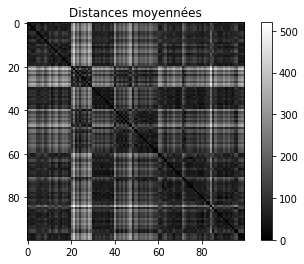

In [108]:
plt.imshow(mat_dist_moy,cmap='gray')
plt.colorbar()
plt.title("Distances moyennées")

Visuellement, il semble apparaître une structure en quadrillage, avec des carrées dont la longueur des côtés sont proportionnels à 10, qui est notre nombre de classes. Par ailleurs, les distances les plus courtes sont proches de la diagonales, ce qui était attendu (les données sont regroupé par classe dans la liste data). Cela montre qu'il y a un lien entre la distance entre deux éléments et le fait d'appartenir à une même classe ou pas.

### 2.b. p@5

La précision à 5 (p@5) permet de mesurer la performance de notre distance pour la classification. Elle compte, parmis les 5 plus proches voisins d'une référence, la proportion d'entre eux qui appartiennent à une même classe.

Moyenne : 0.364


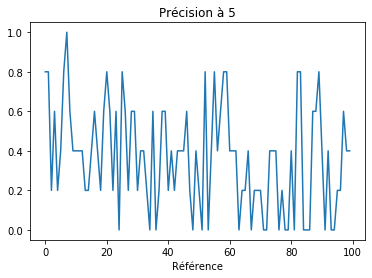

In [145]:
p5 = np.zeros(100)
for k in range(100):
    dist = mat_dist_moy[k,:]
    distsort = np.argsort(np.ravel(dist))
    
    p5[k] = np.sum([label[distsort[i]]==label[k] for i in range(1,6)])/5

plt.plot(p5)
plt.title("Précision à 5")
plt.xlabel('Référence')

print("Moyenne :",np.mean(p5))

On voit que finalement, en moyennes, les plus proches voisins au sens de cette distance, d'un élément ne sont pas nécessairement dans la même classe.

## 3. Distance trame à trame

Ici, la distance entre $M$ et $N$ est calculée en retenant la distance euclidienne entre les deux trames les plus proches de ces deux matrices de MFCC.

### 3.a. Calcul

In [111]:
def dist_trametrame(x,y):
    """La distance entre x et y correspond à la distance entre les deux trames les plus proches."""
    distxy = np.linalg.norm(x-y,axis=1)
    return(distxy[np.where(distxy==min(distxy))[0][0]])

mat_dist_trametrame = np.zeros((100,100))

for i in range(100):
    for j in range(i,100):
        mat_dist_trametrame[i,j] = dist_trametrame(data[i],data[j])
        mat_dist_trametrame[j,i] = mat_dist_trametrame[i,j]
        


Text(0.5, 1.0, 'Distances trame à trame')

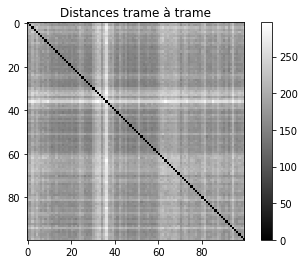

In [114]:
plt.imshow(mat_dist_trametrame,cmap='gray')
plt.colorbar()
plt.title("Distances trame à trame")

Ici il y a moins de structure et la couleur est plus uniforme. Il semble que cette distance soit moins adaptées.

### 3.b. P@5

Moyenne : 0.096


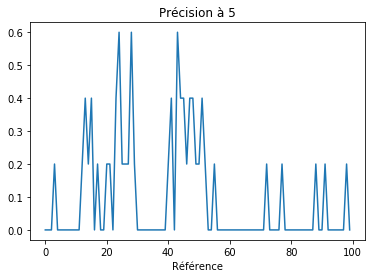

In [146]:
p5 = np.zeros(100)
for k in range(100):
    dist = mat_dist_trametrame[k,:]
    distsort = np.argsort(np.ravel(dist))
    
    p5[k] = np.sum([label[distsort[i]]==label[k] for i in range(1,6)])/5

plt.plot(p5)
plt.title("Précision à 5")
plt.xlabel('Référence')

print("Moyenne :",np.mean(p5))

Ici, les résultats sont encore moins bon que précédemment. Il y a souvent aucun des plus proches voisins d'un élément qui sont dans sa classe.

# Conclusions

On voit donc que l'utilisation de la distance entre moyennes semble être la meilleure parmi les deux pour la classification, mais elle montre néanmoins des faiblesses.